# Input Processing

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scaleogram as scg
import os
import shutil
import posixpath
import wfdb
from wfdb import processing
from PIL import Image
import pywt

## Read all records 

In [2]:
dataset_name = 'afdb'

def read_record(data_path, header, offset=0, sample_size_seconds=30, samples_per_second=250):
    # Sample configuration
    sample_size = sample_size_seconds * samples_per_second
    
    max_sampto = header.sig_len
    sampto = min(max_sampto, offset + sample_size)
    if sampto <= offset:
        return None, None, None
    record = wfdb.rdrecord(data_path + header.record_name, sampfrom=offset, sampto=sampto)
    ann = wfdb.rdann(data_path + header.record_name, 'atr', sampfrom=offset, sampto=sampto)
    return record, ann, sampto
    

def read_records(data_path, sample_size_seconds=30, samples_per_second=250, batch_size=100):
    samples = []
    labels = []
    # Sample configuration
    sample_size = sample_size_seconds * samples_per_second
    
    for record_name in wfdb.get_record_list(dataset_name):
        header = wfdb.rdheader(data_path + record_name)

        if header.sig_len == 0:
            continue

        offset = 0
        samples_count = 0
        while True:
            max_sampto = header.sig_len
            record, ann, offset = read_record(data_path, header, offset, sample_size_seconds, samples_per_second)
            if record is None:
                break
            samples.append(record)
            labels.append(ann.aux_note)
            samples_count += 1
            if batch_size is not None and samples_count == batch_size:
                break

    return samples, labels


samples, labels = read_records('../data/files/', batch_size=1)
print(len(samples), len(labels))

23 23


In [3]:
# dict_labels = {'[\'(N\']': 0, 
#                '[\'(AFIB\']': 1,
#                '[\'(AFIB\', \'(N\']': 0,
#                '[]': 0,
#                '[\'(AFL\']': 0}
labels_formatted = np.array([1 if '(AFIB' in key else 0 for key in labels])
print(labels_formatted)

tp = labels_formatted.sum()
total = len(labels_formatted)
print('Positive cases: {}'.format(tp))
print('Total cases: {}'.format(total))
print('Positive weight: {}%'.format(100 * tp / total))

[0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
Positive cases: 4
Total cases: 23
Positive weight: 17.391304347826086%


In [4]:
header = wfdb.rdheader('../data/files/04043')
record, ann, _ = read_record('../data/files/', header)
display(record.__dict__)

{'record_name': '04043',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 7500,
 'base_time': datetime.time(15, 0),
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.415, -0.395],
        [-0.415, -0.26 ],
        [-0.43 , -0.185],
        ...,
        [ 0.02 , -0.08 ],
        [-0.015, -0.115],
        [-0.07 , -0.125]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['04043.dat', '04043.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-83, -79],
 'checksum': [6241, 53981],
 'block_size': [0, 0]}

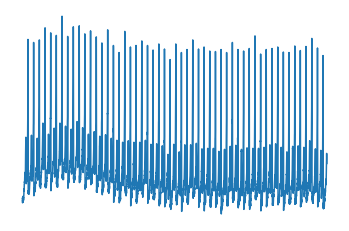

In [5]:
plt.axis('off')
plt.plot(np.arange(record.sig_len), record.p_signal.T[0]) # Select by argmax(SQI)
fig = plt.show()
# 432 × 288

## Wavelet transform

Wavelet decomposition:

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


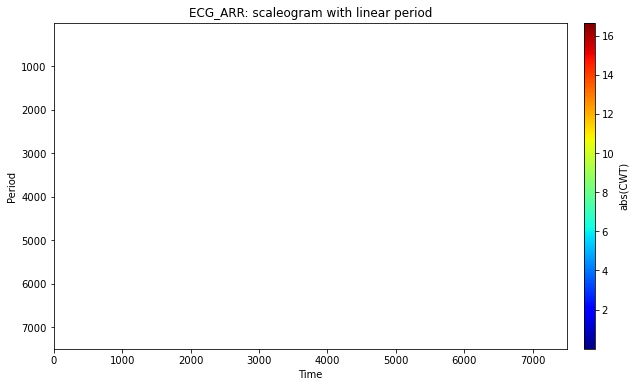

In [6]:
signal = record.p_signal.T[0]

# cwtmatr, freqs = pywt.cwt(signal2, widths, 'cmor2.0-1.0')
# 'cmor2.0-1.0'

# plt.imshow(cwtmatr.real, cmap='PRGn', aspect='auto', 
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
# fig = plt.imshow(cwtmatr.real, cmap='PRGn', aspect='auto', 
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())


# choose default wavelet function 
scg.set_default_wavelet('morl')

signal_length = 7500
# range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, signal_length + 1))
x_values_wvt_arr = range(0, len(signal), 1)

# the scaleogram
scg.cws(signal, scales=scales, figsize=(10, 6), coi=False, ylabel="Period", xlabel="Time",
        title='ECG_ARR: scaleogram with linear period'); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

## Label mapping

In [7]:
# wfdb.show_ann_labels()

## WFDB record:

In [8]:
record = wfdb.rdrecord(data_path + record_name, sampto=sampto)
ann = wfdb.rdann(data_path + record_name, 'atr', sampto=sampto)

# Show pairs of (location, label), where location is the number of sample relative to the start
display(list(zip(ann.sample, ann.symbol)))
display(ann.aux_note)
plt.axis('off')

# fig = wfdb.plot_wfdb(record=record, title='Record' + record_name + 'from MIT-BIH AF dataset',
#                annotation=None,
#                plot_sym=True,
#                time_units='seconds',
#                return_fig=True,
#                figsize=(10,15))

NameError: name 'data_path' is not defined

In [ ]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

data = fig2rgb_array(fig)
# img = Image.fromarray(data, 'RGB')
# img.save('test.png')
# img.show()

# fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

In [ ]:
original = 
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
# Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord(data_path + record_name, sampto = sampto)
annotation = wfdb.rdann(data_path + record_name, 'atr', sampto = sampto)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record '+ record_name  +' from MIT-BIH Arrhythmia Database',
               time_units='seconds')

## ECG Processing

In [ ]:
# Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the WFDB record and the physical samples
record = wfdb.rdrecord(data_path + record_name, sampfrom=0, sampto=sampto, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on record" + record_name)
    

In [ ]:
# Use the XQRS detection algorithm and compare results to reference annotations
import wfdb
from wfdb import processing
sig, fields = wfdb.rdsamp(data_path + record_name, channels=[0], sampto=sampto)
ann_ref = wfdb.rdann(data_path + record_name, 'atr', sampto=sampto)

# Run QRS detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the QRS indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected QRS complexes to reference annotation.
# Note, first sample in 100.atr is not a QRS.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected QRS vs reference annotations')